# 書き込み誤差検討

In [17]:
#------------------------
# Google Colab上でのみ実行
#------------------------
import time
%env TOKEN=*************************************
! git clone https://$$TOKEN@github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

env: TOKEN=*************************************
fatal: destination path 'MOD2NN' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import re
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import stats

from Faraday.two_dim.module.lib.layers import *
from Faraday.two_dim.module.lib import regularizer

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.8.0
Python: 3.8.11 (default, Aug 16 2021, 12:04:33) 
[Clang 12.0.0 ]


In [19]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

In [21]:
model_path = "/content/drive/MyDrive/D2NN/trained_model/20220824/l1_0.000000e+00/seed_1"
model = tf.keras.models.load_model(model_path)
eval = model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 13ms/step - loss: 0.6414 - accuracy: 0.8106


In [22]:
pattern = r'mo'

mo_layers = []
bi_weights = []
error_weights = []

for layer in model.layers:
  result = re.match(pattern, layer.name)
  if result:
      mo_layers.append(layer)
      w = layer.get_weights()
      bi_w = np.where(w[0]>0, np.pi/2, -np.pi/2)
      bi_weights.append(bi_w)

In [28]:
seeds = np.arange(1, 11)
p = np.arange(0, 1.1, 0.1)
acc_table = np.zeros((len(seeds), len(p)))
loss_table = np.zeros((len(seeds), len(p)))

for j, _p in enumerate(p):
  for k, seed in enumerate(seeds):
    for i, layer in enumerate(mo_layers):
        np.random.seed(seed)
        bi_dist = stats.bernoulli.rvs(p=_p, size=(100,100)) * 2 - 1
        w = layer.get_weights()
        w[0] = bi_weights[i] * bi_dist
        layer.set_weights(w)

    bi_eval = model.evaluate(x_test, y_test)
    acc_table[k, j] = bi_eval[1]
    loss_table[k, j] = bi_eval[0]

313/313 [==============================] - 4s 13ms/step - loss: 0.6414 - accuracy: 0.8106


In [35]:
acc_df = pd.DataFrame(acc_table, columns=["{:.1f}".format(t) for t in p])
loss_df = pd.DataFrame(loss_table, columns=["{:.1f}".format(t)  for t in p])

In [36]:
acc_df.to_csv("acc.csv")
loss_df.to_csv("loss.csv")

In [10]:
acc_df = pd.read_csv("acc.csv", index_col=0)
loss_df = pd.read_csv("loss.csv", index_col=0)

In [23]:
float(acc_df.columns[0])

0.0

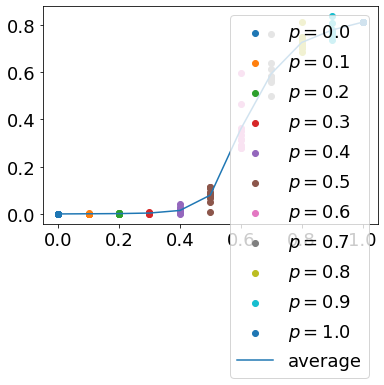

In [31]:
ave = np.average(acc_df.values, axis=0)
for i in range(acc_df.shape[1]):
    x = np.ones_like(acc_df.values[:,i]) * float(acc_df.columns[i])
    y = acc_df.values[:,i]
    plt.scatter(x, y, label=r"$p={:.1f}$".format(float(acc_df.columns[i])))

plt.plot([float(_p) for _p in acc_df.columns], ave, label="average")
plt.legend()